# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (1.) Import the necessary libraries

In [ ]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

### (2.) Change directory

In [ ]:
!ls -l '/content/drive/My Drive/AIML/ACV/Lab_ACV'

total 25969
-rw------- 1 root root 26574193 Sep 13 09:09  images_racoon-1.rar
-rw------- 1 root root     9078 Sep 13 09:20 'LAB - Advanced Computer Vision.ipynb'
-rw------- 1 root root     7913 Sep 13 09:09  train_labels.csv


In [ ]:
import os
os.chdir('/content/drive/My Drive/AIML/ACV/Lab_ACV')

In [ ]:
# SETTINGS
DATASET_FOLDER = '/content/drive/My Drive/AIML/ACV/Lab_ACV/'
TRAIN_CSV = DATASET_FOLDER+"train_labels.csv"
IMAGE_PATH = DATASET_FOLDER + "images_racoon-1/images/"

In [ ]:
!ls -l '/content/drive/My Drive/AIML/ACV/Lab_ACV'

total 25972
-rw------- 1 root root 26574193 Sep 13 09:09  images_racoon-1.rar
-rw------- 1 root root    12001 Sep 13 09:33 'LAB - Advanced Computer Vision.ipynb'
-rw------- 1 root root     7913 Sep 13 09:09  train_labels.csv


### (3.) Load the training data from train.csv file

In [ ]:
train = pd.read_csv('train_labels.csv')

### (4.) Print the shape of the train dataset

In [ ]:
print('Shape of Train Dataset: ', train.shape)

Shape of Train Dataset:  (173, 8)


### (5.) Print the head of the train dataset

In [ ]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### (6.) Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [ ]:
IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

### (7.) With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [ ]:
with open(TRAIN_CSV, 'r') as csvfile:
  paths = []
  coords = np.zeros((sum(1 for line in csvfile)-1, 4))
  #print('Shape of Coordinates: ', coords.shape)
  reader = csv.reader(csvfile, delimiter=',')
  csvfile.seek(0)
  next(reader, None)
  for i, row in enumerate(reader):
    #print(col, row)
    for j, r in enumerate(row):
      #print(r)
      if((j!=0) & (j!=3)):
        #print(row[j])
        row[j] = int(r)
    path, width, height, class_, xmin, ymin, xmax, ymax = row
    paths.append(path)
    coords[i, 0] = xmin * IMAGE_SIZE / width # Normalize bounding box by image size
    coords[i, 1] = ymin * IMAGE_SIZE / height # Normalize bounding box by image size
    coords[i, 2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
    coords[i, 3] = ymax * IMAGE_SIZE / height # Normalize bounding box by image size

In [ ]:
# coordnates
print(len(coords))
print(len(paths))
print(coords[0:10])
print(paths[0:5])

173
173
[[ 46.94980695  39.58762887  82.53281853  77.8556701 ]
 [  0.58181818   0.2962963   89.40606061 127.7037037 ]
 [ 15.78666667  34.24        59.73333333  92.8       ]
 [ 48.42666667  29.76        85.97333333  95.36      ]
 [ 27.19413919  22.83243243  92.36630037  87.87027027]
 [  7.49268293   5.72357724 117.38536585 124.87804878]
 [ 25.38666667   6.72        78.50666667 127.68      ]
 [ 52.47509579   6.63212435 122.11494253 110.09326425]
 [  0.51405622   0.63366337  79.16465863 111.52475248]
 [ 42.996139     5.27835052  89.94594595  58.72164948]]
['raccoon-17.jpg', 'raccoon-11.jpg', 'raccoon-63.jpg', 'raccoon-63.jpg', 'raccoon-60.jpg']


### (8.) Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [ ]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
  img = Image.open(IMAGE_PATH+f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')
  batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))    

### (9.) Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [ ]:
# Alpha Parameter
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

# Load pre-trained mobilenet
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)

# Do not include classification (top) layer
# to freeze layers, except the new top layer, of course, which will be adding below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output

# In the line below kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Conv2D(4, kernel_size=4, name="coords")(x)

# These are the 4 predicted coordinates of one BBox
x = Reshape((4,))(x)

model = Model(inputs=model.input, outputs=x)

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

### (10.) Define a custom loss function IoU which calculates Intersection Over Union

In [ ]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    #iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### (11.) Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [ ]:
gt = coords
PATIENCE=10
# Regression loss is MSE
model.compile(optimizer='Adam', loss='mse', metrics=[IoU])

# Checkpoint best validation model
checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
                              save_weights_only=True, mode="max", save_freq=1)

# Stop early, if the validation error deteriorates
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")

# Reduce learning rate if Validation IOU does not improve
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=PATIENCE, min_lr=1e-7, verbose=1, mode="max")


model.fit(batch_images, gt, epochs=30, batch_size = 32, verbose=1)

Epoch 1/30
6/6 [==============================] - 2s 312ms/step - loss: 77.5665 - IoU: 0.7250
Epoch 2/30
6/6 [==============================] - 2s 311ms/step - loss: 70.3877 - IoU: 0.7664
Epoch 3/30
6/6 [==============================] - 2s 312ms/step - loss: 63.4404 - IoU: 0.7911
Epoch 4/30
6/6 [==============================] - 2s 313ms/step - loss: 58.4436 - IoU: 0.8154
Epoch 5/30
6/6 [==============================] - 2s 311ms/step - loss: 54.7264 - IoU: 0.8373
Epoch 6/30
6/6 [==============================] - 2s 312ms/step - loss: 53.4147 - IoU: 0.8338
Epoch 7/30
6/6 [==============================] - 2s 312ms/step - loss: 57.3412 - IoU: 0.8239
Epoch 8/30
6/6 [==============================] - 2s 315ms/step - loss: 53.9873 - IoU: 0.8229
Epoch 9/30
6/6 [==============================] - 2s 314ms/step - loss: 56.5814 - IoU: 0.8339
Epoch 10/30
6/6 [==============================] - 2s 312ms/step - loss: 54.5138 - IoU: 0.8535
Epoch 11/30
6/6 [==============================] - 2s 312ms

### (12.) Pick a test image from the given data

In [ ]:
# Import cv2
import cv2

# Select any image
filename = IMAGE_PATH+'raccoon-165.jpg'
print(filename)

# Original image for display
unscaled = cv2.imread(filename)

/content/drive/My Drive/AIML/ACV/Lab_ACV/images_racoon-1/images/raccoon-165.jpg


### (13.) Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [ ]:
image_height, image_width, _ = unscaled.shape
# Rescaled image to run the network
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### (14.) Predict the coordinates of the bounding box for the given test image

In [ ]:
# Predict the BBox
region = model.predict(x=np.array([feat_scaled]))[0]

In [ ]:
# Scale the BBox
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

### (15.) Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

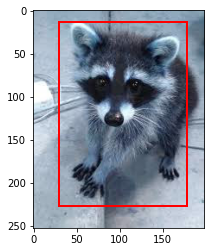

In [ ]:
# Scale the BBox
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

### Testing few other images

/content/drive/My Drive/AIML/ACV/Lab_ACV/images_racoon-1/images/raccoon-25.jpg


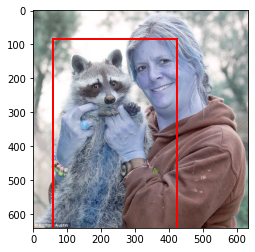

In [ ]:
# Select any random image
filename = IMAGE_PATH+'raccoon-25.jpg'
print(filename)

# Original image for display
unscaled = cv2.imread(filename)

image_height, image_width, _ = unscaled.shape

# Rescaled image to run the network
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

# Predict the BBox
region = model.predict(x=np.array([feat_scaled]))[0]

# Scale the BBox
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

/content/drive/My Drive/AIML/ACV/Lab_ACV/images_racoon-1/images/raccoon-26.jpg


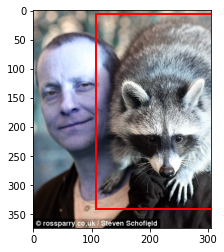

In [ ]:
# Select any random image
filename = IMAGE_PATH+'raccoon-26.jpg'
print(filename)

# Original image for display
unscaled = cv2.imread(filename)

image_height, image_width, _ = unscaled.shape

# Rescaled image to run the network
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

# Predict the BBox
region = model.predict(x=np.array([feat_scaled]))[0]

# Scale the BBox
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

/content/drive/My Drive/AIML/ACV/Lab_ACV/images_racoon-1/images/raccoon-32.jpg


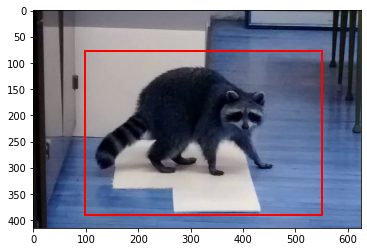

In [ ]:
# Select any random image
filename = IMAGE_PATH+'raccoon-32.jpg'
print(filename)

# Original image for display
unscaled = cv2.imread(filename)

image_height, image_width, _ = unscaled.shape

# Rescaled image to run the network
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

# Predict the BBox
region = model.predict(x=np.array([feat_scaled]))[0]

# Scale the BBox
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

/content/drive/My Drive/AIML/ACV/Lab_ACV/images_racoon-1/images/raccoon-12.jpg


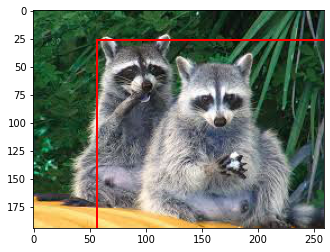

In [ ]:
# Select any random image
filename = IMAGE_PATH+'raccoon-12.jpg'
print(filename)

# Original image for display
unscaled = cv2.imread(filename)

image_height, image_width, _ = unscaled.shape

# Rescaled image to run the network
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

# Predict the BBox
region = model.predict(x=np.array([feat_scaled]))[0]

# Scale the BBox
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

/content/drive/My Drive/AIML/ACV/Lab_ACV/images_racoon-1/images/raccoon-195.jpg


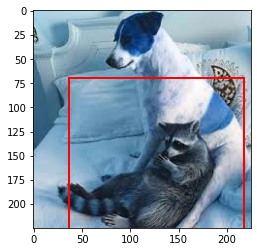

In [ ]:
# Select any random image
filename = IMAGE_PATH+'raccoon-195.jpg'
print(filename)

# Original image for display
unscaled = cv2.imread(filename)

image_height, image_width, _ = unscaled.shape

# Rescaled image to run the network
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

# Predict the BBox
region = model.predict(x=np.array([feat_scaled]))[0]

# Scale the BBox
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

/content/drive/My Drive/AIML/ACV/Lab_ACV/images_racoon-1/images/raccoon-98.jpg


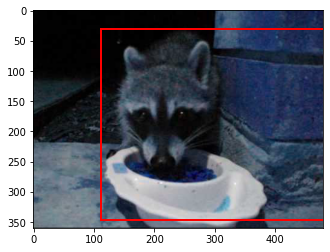

In [ ]:
# Select any random image
filename = IMAGE_PATH+'raccoon-98.jpg'
print(filename)

# Original image for display
unscaled = cv2.imread(filename)

image_height, image_width, _ = unscaled.shape

# Rescaled image to run the network
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

# Predict the BBox
region = model.predict(x=np.array([feat_scaled]))[0]

# Scale the BBox
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()